# Generate and visualize toy data sets

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit-0.0.0-py3.7.egg/zfit/util/execution.py:70: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


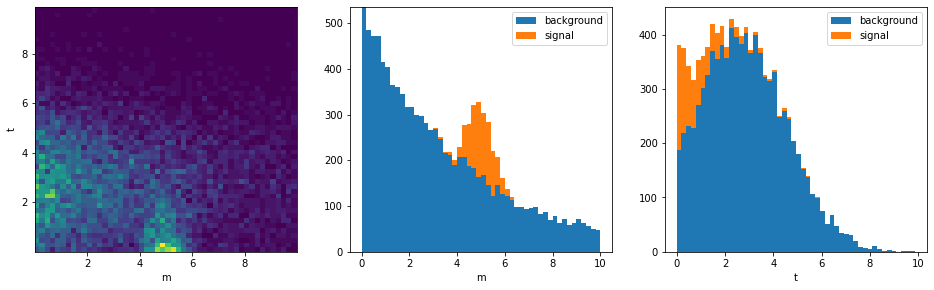

In [1]:
import zfit
import numpy as np
from scipy.stats import norm, expon
from matplotlib import pyplot as plt

zfit.settings.set_seed(10) # fix seed

bounds = (0, 10)
obs = zfit.Space('x', limits=bounds)

# true parameters for signal and background
truth_n_sig = 1000
Nsig = zfit.Parameter("Nsig", truth_n_sig)
mean_sig = zfit.Parameter("mean_sig", 5.0)
sigma_sig = zfit.Parameter("sigma_sig", 0.5)
sig_pdf = zfit.pdf.Gauss(obs=obs, mu=mean_sig, sigma=sigma_sig).create_extended(Nsig)

truth_n_bkg = 10000
Nbkg = zfit.Parameter("Nbkg", truth_n_bkg)
lambda_bkg = zfit.Parameter("lambda_bkg", -1/4.0)
bkg_pdf = zfit.pdf.Exponential(obs=obs, lambda_=lambda_bkg).create_extended(Nbkg)

truth_sig_t = (1.0,)
truth_bkg_t = (2.5, 2.0)

# make a data set
m_sig = sig_pdf.sample(truth_n_sig).numpy()
m_bkg = bkg_pdf.sample(truth_n_bkg).numpy()
m = np.concatenate([m_sig, m_bkg]).flatten()

# fill t variables
t_sig = expon(0, *truth_sig_t).rvs(truth_n_sig)
t_bkg = norm(*truth_bkg_t).rvs(truth_n_bkg)
t = np.concatenate([t_sig, t_bkg])

# cut out range (0, 10) in m, t
ma = (bounds[0] < t) & (t < bounds[1])
m = m[ma]
t = t[ma]

fig, ax = plt.subplots(1, 3, figsize=(16, 4.5))
ax[0].hist2d(m, t, bins=(50, 50))
ax[0].set_xlabel("m")
ax[0].set_ylabel("t")
ax[1].hist([m_bkg, m_sig], bins=50, stacked=True, label=("background", "signal"))
ax[1].set_xlabel("m")
ax[1].legend()
ax[2].hist((t[truth_n_sig:], t[:truth_n_sig]), bins=50, stacked=True, label=("background", "signal"))
ax[2].set_xlabel("t")
ax[2].legend();

sorter = np.argsort(m)
m = m[sorter]
t = t[sorter]

#  Fit toy data set

In [2]:
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

tot_pdf = zfit.pdf.SumPDF([sig_pdf, bkg_pdf])
loss = ExtendedUnbinnedNLL(model=tot_pdf, data=zfit.data.Data.from_numpy(obs=obs, array=m))

minimizer = Minuit()

minimum = minimizer.minimize(loss=loss)
minimum.hesse()
print(minimum)

------------------------------------------------------------------
| FCN = -6.075E+04              |     Ncalls=123 (123 total)     |
| EDM = 0.000278 (Goal: 5E-05)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_1, Composed_autoparam_2] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7fdf17687490>] constraints=[]> 
w

## Visualize fitted model

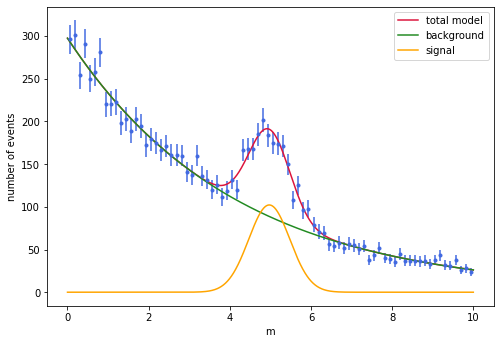

In [3]:
from utils import pltdist, plotfitresult 

fig = plt.figure(figsize=(8, 5.5))

nbins = 80
pltdist(m, nbins, bounds)
plotfitresult(tot_pdf, bounds, nbins, label="total model", color="crimson")
plotfitresult(bkg_pdf, bounds, nbins, label="background", color="forestgreen")
plotfitresult(sig_pdf, bounds, nbins, label="signal", color="orange")
plt.xlabel("m")
plt.ylabel("number of events")
plt.legend();

##  Compute sWeights

In [4]:
from hepstats.splot import compute_sweights

weights = compute_sweights(tot_pdf, m)

print("Sum of signal sWeights: ", np.sum(weights[Nsig]))

Sum of signal sWeights:  1038.6871820897331


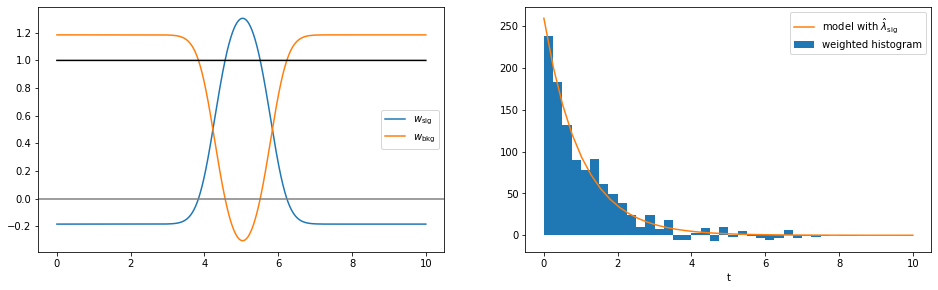

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))
plt.sca(ax[0])
nbins = 40

plt.plot(m, weights[Nsig], label="$w_\\mathrm{sig}$")
plt.plot(m, weights[Nbkg], label="$w_\\mathrm{bkg}$")
plt.plot(m, weights[Nsig] + weights[Nbkg], "-k")
plt.axhline(0, color="0.5")
plt.legend()
plt.sca(ax[1]) 

plt.hist(t, bins=nbins, range=bounds, weights=weights[Nsig], label="weighted histogram")
t1 = np.linspace(*bounds, nbins)
tcdf = expon(0, 1).pdf(t1) * np.sum(weights[Nsig]) * (bounds[1] - bounds[0])/nbins
plt.plot(t1, tcdf, label="model with \lambda_\\mathrm{sig}$")
plt.xlabel("t")
plt.legend();